# Web attack detection using CICIDS2017 dataset

Training data: "Intrusion Detection Evaluation Dataset" (CICIDS2017). Description page: https://www.unb.ca/cic/datasets/ids-2017.html

The data set is public. Download link: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/

CICIDS2017 combines 8 files recorded on different days of observation (PCAP + CSV). Used archive: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip

In the downloaded archive GeneratedLabelledFlows.zip the file "Thursday" Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv is selected.

Sources:

* [Sharafaldin2018] Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 2018
* [Kostas2018] Kahraman Kostas. Anomaly Detection in Networks Using Machine Learning. 2018 (error was found in assessing the importance of features)
* https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning (error was found in assessing the importance of features)

## Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

We use "engine=python" to avoid the "UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 11: invalid start byte" encoding error.

In [2]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python')

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv file contains 458968 records, 85 columns.

In [3]:
df.shape

(458968, 85)

The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.

In [4]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

In [5]:
df['Label'].unique()

array(['BENIGN', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection', nan], dtype=object)

In [6]:
df['Label'].value_counts()

BENIGN                        168186
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Web Attack – Sql Injection        21
Name: Label, dtype: int64

Delete blank records.

In [7]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

Replace the NaN values with zeros.

In [8]:
df.fillna(0, inplace=True)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [9]:
df = df.replace('Infinity', -1)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [10]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [11]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [12]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [13]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [14]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

BENIGN                        168186
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Web Attack – Sql Injection        21
Name: Label, dtype: int64

We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:

    1. The next record is copyied with the benign_inc_probability.
    2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [15]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [16]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [17]:
df_balanced['Label'].value_counts()

BENIGN                        5087
Web Attack – Brute Force      1507
Web Attack – XSS               652
Web Attack – Sql Injection      21
Name: Label, dtype: int64

If necessary, we keep a single class of attack for experiments.

In [18]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [19]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

## Preparing data for training

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [20]:
df = pd.read_csv('web_attacks_balanced.csv')
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded)

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset. 

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

    Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
    Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

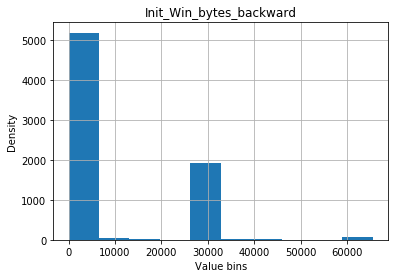

In [21]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

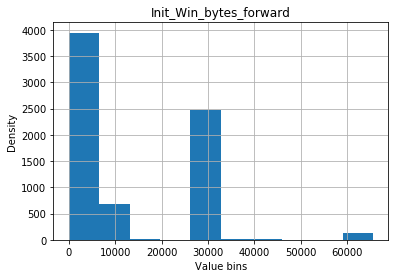

In [22]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [23]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2)

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [24]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


## Feature importance

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3529, 1: 1557}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)

In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.

By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree.export import export_text
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.94302554, 0.92730845, 0.95481336, 0.95481336, 0.95284872,
       0.97249509, 0.94499018, 0.97244094, 0.9507874 , 0.94871795])

In [27]:
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.67
|   |--- Fwd IAT Std <= 2471538.25
|   |   |--- class: 0
|   |--- Fwd IAT Std >  2471538.25
|   |   |--- class: 1
|--- Packet Length Mean >  0.67
|   |--- Subflow Fwd Bytes <= 37131.00
|   |   |--- Bwd IAT Min <= 824.00
|   |   |   |--- class: 0
|   |   |--- Bwd IAT Min >  824.00
|   |   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  37131.00
|   |   |--- class: 1



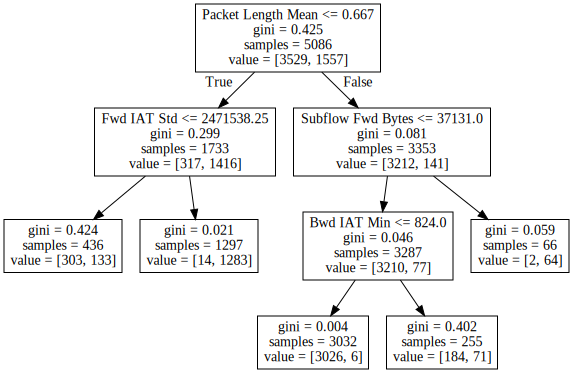

In [28]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

Analyze the confusion matrix. Which classes are confidently classified by the model?

In [29]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1558, 1: 623}

In [30]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1544,   14],
       [  70,  553]], dtype=int64)

### Importance evaluation using SelectFromModel (still one decision tree)

https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [31]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16694136, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01964859, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.75008695,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0633231 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [32]:
sfm.threshold_

0.013513513513513513

In [33]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [34]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7500869459345867
1.	Fwd IAT Std - 0.16694136316914082
2.	Subflow Fwd Bytes - 0.06332310202079924
3.	Bwd IAT Min - 0.01964858887547314
4.	Idle Min - 0.0
5.	Bwd IAT Mean - 0.0
6.	Fwd IAT Mean - 0.0
7.	Fwd IAT Max - 0.0
8.	Fwd IAT Min - 0.0
9.	Bwd IAT Total - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [36]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices[:20]:
    print('#{}\t{:.3f}\t{}'.format(i, importances[i], features[i]))

#13	0.085	Flow Bytes/s
#51	0.078	Average Packet Size
#38	0.063	Max Packet Length
#39	0.059	Packet Length Mean
#7	0.057	Fwd Packet Length Mean
#23	0.051	Fwd IAT Min
#61	0.051	Subflow Fwd Bytes
#3	0.051	Total Length of Fwd Packets
#52	0.047	Avg Fwd Segment Size
#15	0.033	Flow IAT Mean
#5	0.032	Fwd Packet Length Max
#21	0.029	Fwd IAT Std
#0	0.024	Flow Duration
#22	0.023	Fwd IAT Max
#33	0.023	Fwd Header Length
#35	0.023	Fwd Packets/s
#14	0.021	Flow Packets/s
#16	0.020	Flow IAT Std
#17	0.020	Flow IAT Max
#20	0.017	Fwd IAT Mean


For comparison, the results of the study [Sharafaldin2018] (compare relatively, without taking into account the multiplier):

* Init Win F.Bytes 0.0200
* Subflow F.Bytes 0.0145
* Init Win B.Bytes 0.0129
* Total Len F.Packets 0.0096

And incorrect results [Kostas2018] (error was found in assessing the importance of features, line: *impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})*, the importances[0:20] sample does not take into account that the values are not sorted in descending order):

* Flow Bytes/s 0.313402
* Total Length of Fwd Packets 0.304917
* Flow Duration 0.000485
* Fwd Packet Length Max 0.00013

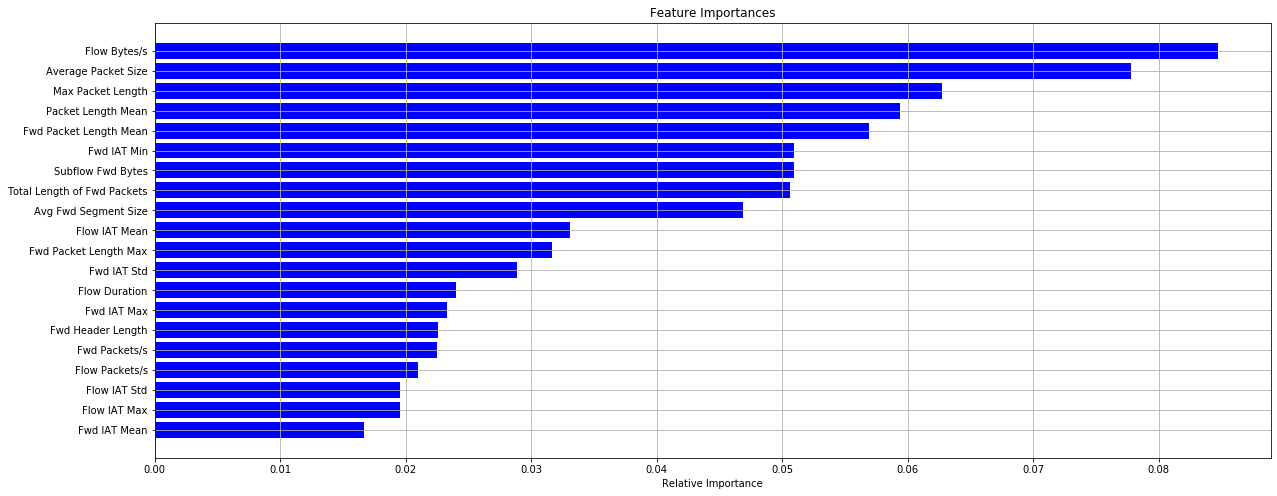

In [37]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (20, 8)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300)
plt.show()

Make sure that SelectFromModel shows the same results.

In [38]:
sfm = SelectFromModel(estimator=rf).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([2.40103388e-02, 8.78946132e-03, 3.48018957e-03, 5.06014184e-02,
       9.34711792e-03, 3.16965105e-02, 1.90769144e-04, 5.69161901e-02,
       4.21952471e-03, 4.31229352e-03, 1.90502381e-04, 4.34604749e-03,
       2.17203777e-03, 8.47048022e-02, 2.10052740e-02, 3.30867311e-02,
       1.95883695e-02, 1.95351897e-02, 1.35079800e-02, 1.49652658e-02,
       1.67203188e-02, 2.88718609e-02, 2.33118999e-02, 5.09405594e-02,
       3.50279631e-03, 2.64124579e-03, 2.17739962e-03, 4.09040649e-03,
       4.40353581e-03, 1.22998284e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.25429525e-02, 1.39462832e-02, 2.25205481e-02,
       9.54286343e-03, 6.36533402e-04, 6.27094586e-02, 5.94064736e-02,
       6.43428150e-03, 5.74726234e-03, 0.00000000e+00, 3.73088286e-06,
       0.00000000e+00, 9.99963267e-03, 8.87483645e-03, 4.55362878e-03,
       0.00000000e+00, 0.00000000e+00, 1.70720989e-03, 7.77760313e-02,
       4.68490255e-02, 4.28876069e-03, 0.00000000e+00, 0.00000000e+00,
      

In [39]:
sfm.threshold_

0.013513513513513514

In [40]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 22


In [41]:
indices = np.argsort(rf.feature_importances_)[::-1]
webattack_features = []
for idx, i in enumerate(indices):
    webattack_features.append(X_train.columns[i])
    if idx < 20:
        print("{}.\t{} - {}".format(idx, X_train.columns[i], rf.feature_importances_[i]))

0.	Flow Bytes/s - 0.08470480216316158
1.	Average Packet Size - 0.07777603131112241
2.	Max Packet Length - 0.06270945859436221
3.	Packet Length Mean - 0.05940647358045754
4.	Fwd Packet Length Mean - 0.056916190137985136
5.	Fwd IAT Min - 0.050940559377513496
6.	Subflow Fwd Bytes - 0.05093743371511307
7.	Total Length of Fwd Packets - 0.05060141839089613
8.	Avg Fwd Segment Size - 0.04684902551379232
9.	Flow IAT Mean - 0.033086731139964985
10.	Fwd Packet Length Max - 0.03169651050041796
11.	Fwd IAT Std - 0.028871860887762175
12.	Flow Duration - 0.02401033878277692
13.	Fwd IAT Max - 0.023311899927945464
14.	Fwd Header Length - 0.022542952485365378
15.	Fwd Packets/s - 0.022520548139611546
16.	Flow Packets/s - 0.02100527402411318
17.	Flow IAT Std - 0.019588369515609723
18.	Flow IAT Max - 0.01953518968159231
19.	Fwd IAT Mean - 0.016720318788524265


Once again we analyze the confusion matrix, now for a higher quality classifier. A random forest also badly distinguishes between separate attack classes ("Web Attack – XSS" is very similar to "Web Attack – Brute Force"). At the same time, the "BENIGN" class is well separated from the others.

If we combine different attack classes into one "web attack" class, the resulting binary classifier will show high quality.

In [42]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1535,   23],
       [  24,  599]], dtype=int64)

Next, for experiments, we keep the first max_features of features with maximum importance.

In [43]:
max_features = 10
webattack_features = webattack_features[:max_features]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Subflow Fwd Bytes',
 'Total Length of Fwd Packets',
 'Avg Fwd Segment Size',
 'Flow IAT Mean']

## Analysis of selected features

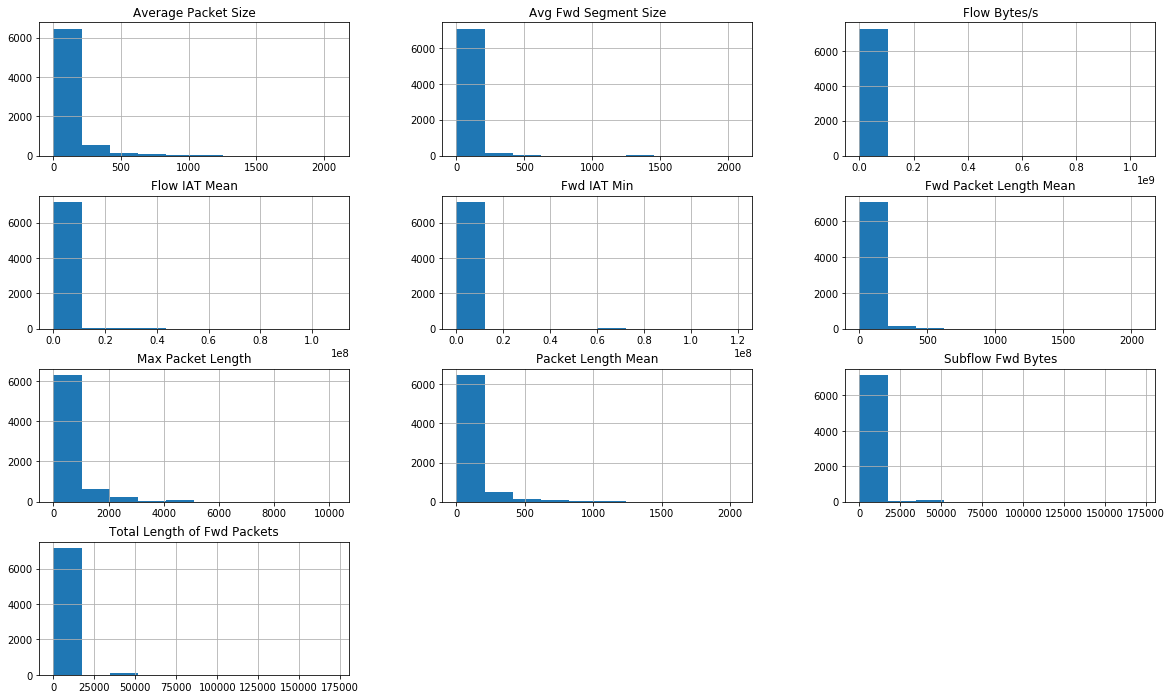

In [44]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

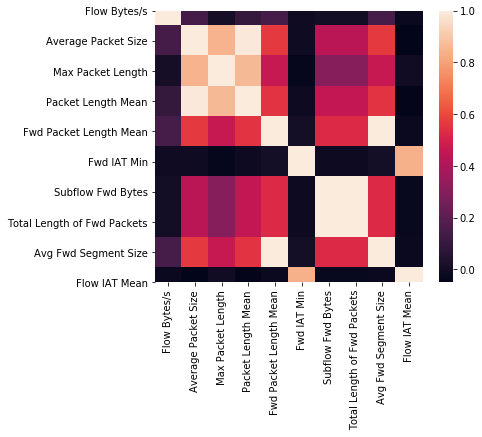

In [45]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix);
plt.savefig('corr_heatmap.png', dpi=300)

## Hyperparameter selection

Reopen the dataset.

In [46]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else (0 if random.random() < 0 else 1))
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


We get the list of RandomForestClassifier parameters.

In [47]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [48]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
%time gcv.fit(X, y)
results = gcv.cv_results_

Wall time: 8.81 s


In [49]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_accuracy,...,split2_train_f1,split3_train_f1,split4_train_f1,split5_train_f1,split6_train_f1,split7_train_f1,split8_train_f1,split9_train_f1,mean_train_f1,std_train_f1
0,0.020044,0.00238,0.004491,0.000799,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.935351,...,0.860426,0.858852,0.857961,0.858441,0.852739,0.854742,0.855427,0.857211,0.856657,0.002371


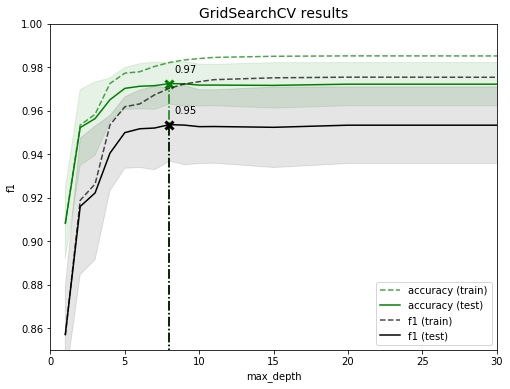

In [50]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 6))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(0, 30)
ax.set_ylim(0.85, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

Grid search.

In [51]:
parameters = {'n_estimators': [50, 100], 
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10], 
              'max_depth': [17, 23]}

# parameters = {'n_estimators': [100], 'max_features': [10]}

In [52]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
%time gcv.fit(X, y)

Wall time: 5min 11s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

Let's take a look at the results of the parameter selection.

In [53]:
gcv.best_estimator_ 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [54]:
gcv.best_params_

{'max_depth': 23, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 50}

In [55]:
gcv.best_score_

0.9551350888612173

## Model saving

In [56]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(gcv.best_estimator_, f)

## Model approbation

Open the previously saved model.

In [57]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=23, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Reopen the dataset.

In [58]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(7267, 10) (7267,)


In [59]:
X_test

,Flow Bytes/s,Average Packet Size,Max Packet Length,Packet Length Mean,Fwd Packet Length Mean,Fwd IAT Min,Subflow Fwd Bytes,Total Length of Fwd Packets,Avg Fwd Segment Size,Flow IAT Mean
0,1.740123e+02,278.930556,923.0,275.109589,201.416667,3.0,9668.0,9668.0,201.416667,1.592894e+06
1,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,8.050035e+05
2,7.619048e+05,48.000000,48.0,38.400000,32.000000,49.0,64.0,64.0,32.000000,7.000000e+01
3,1.065574e+06,75.000000,90.0,60.000000,40.000000,3.0,80.0,80.0,40.000000,8.133333e+01
4,3.635433e+03,80.750000,103.0,64.600000,39.000000,3.0,78.0,78.0,39.000000,2.604000e+04
...,...,...,...,...,...,...,...,...,...,...
7262,6.472417e+03,182.931035,1398.0,176.833333,64.470588,19.0,1096.0,1096.0,64.470588,2.927257e+04
7263,2.169328e+03,299.777778,1448.0,269.800000,107.750000,32706.0,431.0,431.0,107.750000,1.554629e+05
7264,7.838121e+03,181.787879,1418.0,176.441176,53.578947,1.0,1018.0,1018.0,53.578947,2.391756e+04
7265,9.425526e+02,293.705882,1448.0,277.388889,35.300000,48.0,353.0,353.0,35.300000,3.310823e+05


In [60]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.03490614891052246 seconds
Benign records detected (0), attacks detected (1):


{0: 5099, 1: 2168}

Confusion matrix (матрица ошибок):

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

In [61]:
confusion_matrix(y_test, y_pred)

array([[5042,   45],
       [  57, 2123]], dtype=int64)

In [62]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

Precision = 0.9792435424354243
Recall = 0.9738532110091743
F1 = 0.9765409383624655
Accuracy = 0.9859639466079537


Manual calculation of the confusion matrix:
    
    array([[5075,   12],
           [   1, 2179]], dtype=int64)
  
      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

    Точность
    Precision = TP / (TP + FP) = 2179 / (2179 + 12) = 0.9945230488361478

    Полнота
    Recall = TP / (TP + FN) = 2179 / (2179 + 1) = 0.9995412844036697

    F-мера, параметр = 1, гармоническое среднее точности и полноты, множитель = 2
    F1 = 2 * (precision * recall) / (precision + recall) = 0.9970258522077328

    Доля правильных ответов
    Accuracy = TP + TN / (TP + TN + FP + FN) = (2179 + 5075) / 7267 = 0.998211091234347

In [63]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [64]:
result[result['Predict'] == 1]

,Flow Bytes/s,Average Packet Size,Max Packet Length,Packet Length Mean,Fwd Packet Length Mean,Fwd IAT Min,Subflow Fwd Bytes,Total Length of Fwd Packets,Avg Fwd Segment Size,Flow IAT Mean,Label,Predict
209,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,71.0000,0,1
211,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,71.0000,0,1
316,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,105.0000,0,1
428,644.729782,238.785714,1047.0,222.866667,146.000000,4.0,1022.0,1022.0,146.000000,398855.2308,1,1
434,455.121233,199.916667,1066.0,184.538462,138.428571,323.0,969.0,969.0,138.428571,479193.0000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6691,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,80.0000,0,1
6732,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,77.0000,0,1
6811,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,94.0000,0,1
6882,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,62.0000,0,1


In [65]:
result[410:430]

,Flow Bytes/s,Average Packet Size,Max Packet Length,Packet Length Mean,Fwd Packet Length Mean,Fwd IAT Min,Subflow Fwd Bytes,Total Length of Fwd Packets,Avg Fwd Segment Size,Flow IAT Mean,Label,Predict
410,3.939394e+05,23.666667,53.0,17.750000,21.666667,48.0,65.0,65.0,21.666667,8.250000e+01,0,0
411,3.606391e+04,328.153846,1430.0,304.714286,64.625000,48.0,517.0,517.0,64.625000,9.857500e+03,0,0
412,4.450555e+04,351.076923,1460.0,326.000000,68.625000,49.0,549.0,549.0,68.625000,8.545750e+03,0,0
413,3.214549e+04,330.529412,1460.0,312.166667,159.555556,49.0,1436.0,1436.0,159.555556,1.092494e+04,0,0
414,2.172302e+00,3.000000,6.0,2.400000,4.000000,23107.0,12.0,12.0,4.000000,1.841364e+06,0,0
415,4.987631e+01,201.931035,2549.0,195.200000,64.266667,46.0,964.0,964.0,64.266667,4.193230e+06,0,0
416,5.008038e+03,106.500000,111.0,71.000000,51.000000,0.0,51.0,51.0,51.000000,3.234800e+04,0,0
417,1.188526e+04,68.833333,99.0,59.000000,43.000000,4.0,172.0,172.0,43.000000,6.226200e+03,0,0
418,2.134228e+06,89.750000,118.0,71.800000,41.000000,3.0,82.0,82.0,41.000000,4.966667e+01,0,0
419,1.271523e+06,58.000000,56.0,46.400000,40.000000,4.0,80.0,80.0,40.000000,5.033333e+01,0,0
